In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import xarray as xr
from frites.conn import conn_reshape_undirected
# Import plot functions from current repo
import sys
sys.path.append('../')
from plot.plot_marsatlas import plot_marsatlas
from plot.plot_fcd import plot_fcd_circular_xr
import matplotlib.gridspec as gridspec
import pandas as pd
from ggseg import ggplot_marsatlas
import math
import matplotlib.cm as cm
from sklearn.decomposition import NMF

## Suppl Figure 1. Behavioural results and model fitting

In [2]:
# Load regressors data
Results_Dir = '/home/INT/brovelli.a/code/hosi_infogain/data/'
fname = Results_Dir + 'regs_all.xlsx'
# Load xls file
regs = pd.read_excel(fname, sheet_name="Sheet1")

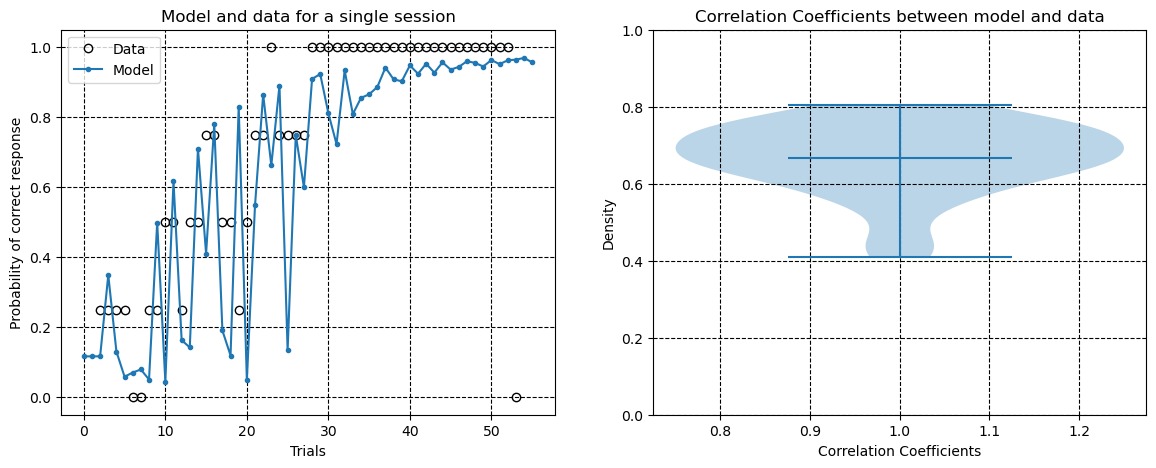

In [11]:
# Find the beginning of each session as regs["trial"] == 1
ind = np.where(regs["trial"] == 1)[0]
# Number of trials per session
n_trials = np.diff(ind)
corrcoef_all = []
p_val_all = []
# Loop over sessions
for n, i in enumerate(ind[0:-1]):
    # Init p_cor
    p_cor = np.zeros(n_trials[n])
    # Loop over trials
    for j in range(2, n_trials[n]-3):
        p_cor[j] = np.mean(regs["O"].iloc[i+j-2:i+j+2])
    # Plot an exemplar session of the model and data
    session = 12
    if i == ind[session]:
        # Plot the data and the model in the first panel of a
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        axs[0].plot(range(2, n_trials[n]-2), p_cor[2:-2], label="Data", color="black", marker="o", linestyle="None", markerfacecolor="None")
        axs[0].plot(range(n_trials[n]), regs["Pcor"].iloc[ind[session]:ind[session+1]],marker=".", label="Model")
        axs[0].set_xlabel("Trials")
        axs[0].set_ylabel("Probability of correct response")
        axs[0].legend()
        axs[0].set_title("Model and data for a single session")
        # add grid
        axs[0].grid()
    # Compute the correlation between the model and the data
    corrcoef, p_val = pearsonr(p_cor[2:-2], regs["Pcor"].iloc[ind[n]+2:ind[n+1]-2].values)
    # Append the correlation coefficient across sessions
    corrcoef_all.append(corrcoef)
    p_val_all.append(p_val)
    
# Second panel: Plot the histogram
axs[1].violinplot(corrcoef_all, showmeans=True)
axs[1].set_xlabel("Correlation Coefficients")
axs[1].set_ylabel("Density")
axs[1].set_title("Correlation Coefficients between model and data")
# Put y-limit to 0 and 1
axs[1].set_ylim(0, 1)
axs[1].grid()

# Show the plot
plt.show()

## Suppl Figure 2. Correlations between Information Gain and RPE, Uncertainties


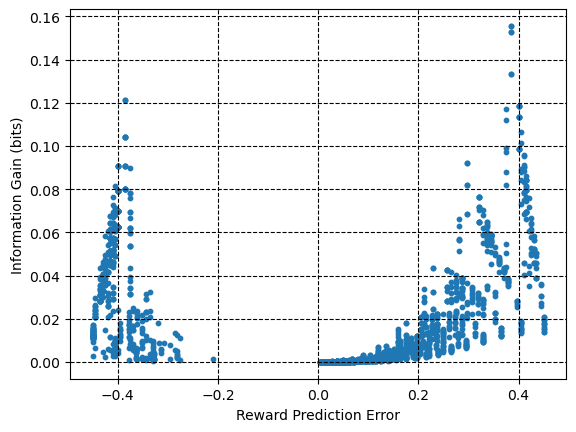

In [4]:
# Load regressors data
Results_Dir = '/home/INT/brovelli.a/code/hosi_infogain/data/'
fname = Results_Dir + 'regs_all.xlsx'
# Load xls file
regs = pd.read_excel(fname, sheet_name="Sheet1")
# Plot the relation between info gain and rpe
plt.figure()
plt.scatter(regs['rpe'], regs['infogain'], s=10)
plt.ylabel('Information Gain (bits)')
plt.xlabel('Reward Prediction Error')
plt.grid()
plt.show()

## Suppl Figure 3. Heat map of Information gain activations on the brain


In [5]:
# Load GCMI data
Results_Dir = '/home/INT/brovelli.a/code/hosi_infogain/data/'
fname = Results_Dir + 'outcome_infogain_gcmi.nc'
data = xr.load_dataset(fname)

# Stats params
threshold = 0.05
title = 'Outcome Information Gain' + ' p<' + str(threshold)

# Prepare data for plotting
gcmi = data['mi']
gcmi_tval = data['tval']
pvalues = data['pv']
allroi = data.roi
nroi = len(allroi)
times = data.times
labels = gcmi.roi

In [6]:
def create_data_ggplot(dt, tmin=-0.7, tmax=1.):

    # data selection
    mi = dt['mi'].copy()
    pv = dt['pv'] < 0.05

    # roi selection
    # crop times
    mi = mi.sel(times=slice(tmin, tmax))
    pv = pv.sel(times=slice(tmin, tmax))
    is_roi = pv.any('times').values
    assert np.any(is_roi)
    mi_s = mi.sel(roi=is_roi)
    pv_s = pv.sel(roi=is_roi)
    mi_s.data[~pv_s.data] = np.nan
    mi_parc = mi_s.mean('times')       

    indices = np.where(pv.any('times').values)[0]
    
    # Create labels from indices from dt['roi']
    labels = [dt['roi'].data[i] for i in indices]
    
    data = {k: v for k, v in zip(labels, mi_parc.data)}     

    return data


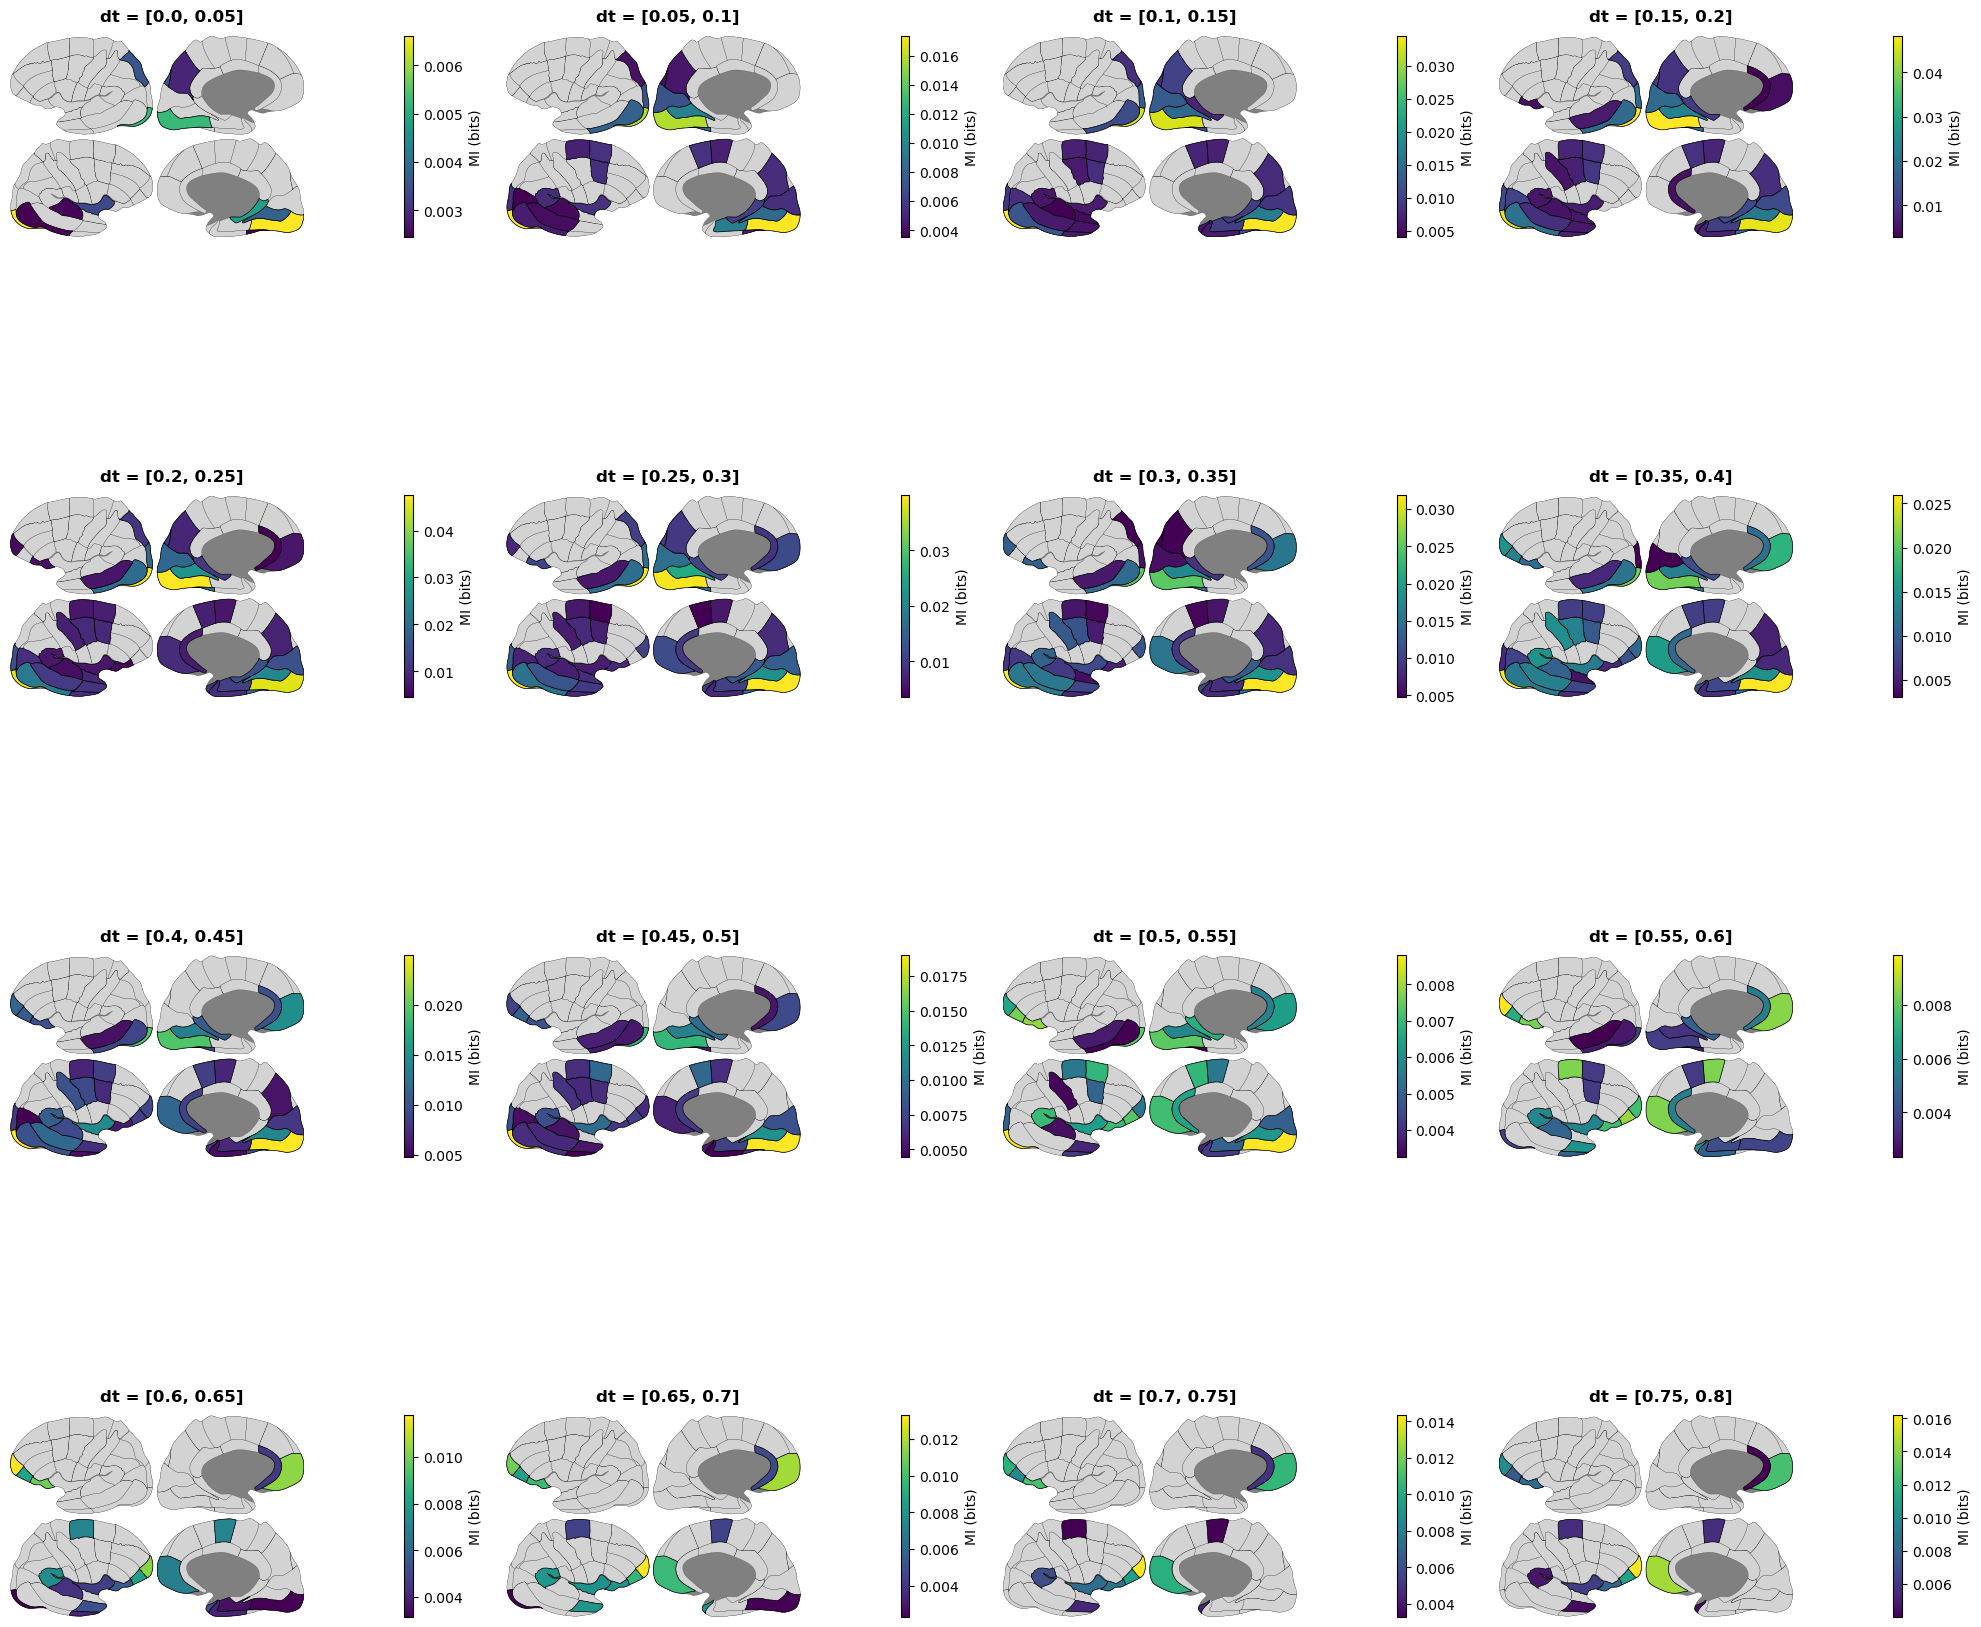

In [7]:
# Define start and end times
start_time = 0.
end_time = 0.8

# Define step
step = 0.05

# Generate time intervals
time_intervals = [(start, start + step) for start in np.arange(start_time, end_time, step)]

# Calculate number of rows and columns for subplots
n = len(time_intervals)
rows = 4
cols = int(np.ceil(n / rows))

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))

# Flatten axs for easy iteration
axs = axs.flatten()

for i, (tmin, tmax) in enumerate(time_intervals):
    data_slice = create_data_ggplot(data, tmin=tmin, tmax=tmax)
    # Check whether data  is not empty otherwise skip
    if not data_slice:
        continue
    # Round tmin and tmax to 2 decimal places
    tmin = round(tmin, 2)
    tmax = round(tmax, 2)
    title = f"dt = [{tmin}, {tmax}]"
    # select the correct subplot
    plt.subplot(rows, cols, i+1)
    ggplot_marsatlas(
        data_slice, ylabel="MI (bits)", fontsize=4, cmap='viridis',
        title=title, cbar_loc='right', ax=plt.gca())

plt.tight_layout()
plt.show()

## Suppl Figure 4. Higher-order synergistic interactions with multiple plots

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import xarray as xr
from sklearn.decomposition import NMF
import xarray as xr
import matplotlib.cm as cm
import operator
import networkx as nx
import xgi

In [9]:
# Load data
fname = Results_Dir + 'outcome_infogain_cluster_hoi_synergy.nc'
ds = xr.load_dataset(fname)

# Thresholded data
# data_mi = ds.hoi  * (ds.pv <= 0.05)
data = ds.tv * (ds.pv <= 0.05)
data_sign = ds.tv  * (ds.pv <= 0.05)

# Select time interval
data = data.sel(times=slice(-0.1, 1.))

# Select link with non zero entries in the matrix
data = data.sel(links=data_sign.links[data_sign.sum('times') != 0])

# Calculate the order of each link (multiplet)
# (i.e. the number of '-' in the label of the two nodes of the link)
labels = data['links']
order = [len([c for c in s if c == '-']) for s in labels.values]
# adde 1 to the order to avoid 0
order = np.array(order) + 1
order = np.array(order)
# add dimension with tplt.subplots_adjust(wspace=0.3)he valuers of order to the dataframe
data['order'] = ('links', order)

# Tranform to dataframe
data = data.T
df = data.to_pandas()

In [10]:
# 2D positions of clusters
delta_ang = (np.pi - 0.8)/5
aa = np.pi/2-0.4
# Coordinates 
R_dlPFC_y = np.sin((aa-delta_ang*1.25))
R_dlPFC_x = np.cos((aa-delta_ang*1.25))
R_MotPM_y = np.sin((aa-delta_ang*2.5))
R_MotPM_x = np.cos((aa-delta_ang*2.5))
R_Temporal_y = np.sin((aa-delta_ang*3.75))
R_Temporal_x = np.cos((aa-delta_ang*3.75))
R_vmPFCOFC_y = np.sin((aa))
R_vmPFCOFC_x = np.cos((aa))
L_vmPFCOFC_y = np.sin((aa+0.8))
L_vmPFCOFC_x = np.cos((aa+0.8))
L_Visual_y = np.sin((-aa-0.8))
L_Visual_x = np.cos((-aa-0.8))
R_Visual_y = np.sin((-aa))
R_Visual_x = np.cos((-aa))
# Transform to dictionary
coord = {'L Vis': (L_Visual_x, L_Visual_y),
         'R Vis': (R_Visual_x, R_Visual_y),
         'L Par': (-1, 0.),
         'R Temp': (R_Temporal_x, R_Temporal_y),
         'R MotPM': (R_MotPM_x,R_MotPM_y),
         'R dlPFC': (R_dlPFC_x, R_dlPFC_y),
         'L vmOFC': (L_vmPFCOFC_x,L_vmPFCOFC_y),
         'R vmOFC': (R_vmPFCOFC_x, R_vmPFCOFC_y)}     
dt = 0.12
coord_double = {'L Vis': (L_Visual_x, L_Visual_y-dt),
         'R Vis': (R_Visual_x, R_Visual_y-dt),
         'L Par': (-1., dt),
         'R Temp': (R_Temporal_x+0.1, R_Temporal_y-dt),
         'R MotPM': (R_MotPM_x,R_MotPM_y+dt),
         'R dlPFC': (R_dlPFC_x, R_dlPFC_y+dt),
         'L vmOFC': (L_vmPFCOFC_x,L_vmPFCOFC_y+dt),
         'R vmOFC': (R_vmPFCOFC_x, R_vmPFCOFC_y+dt)}   
node_id = {0: 'L Vis',
         1:  'R Vis',
         2: 'L Par',
         3: 'R Temp',
         4: 'R PM',
         5: 'R dlPFC',
         6: 'L vmPFC-OFC',
         7: 'R vmPFC-OFC'}       
# Crete pos for xgi
pos = np.array(list(coord.values()))
pos_double = np.array(list(coord_double.values()))

In [11]:
#-----------------------------------------------
# Analysis of temporal hypergraph representation
#-----------------------------------------------
# ROI labels
list_rois = ['L_Visual', 'R_Visual', 'L_Parietal', 'R_Temporal', 'R_MotPM', 'R_dlPFC' , 'L_vmPFCOFC','R_vmPFCOFC']
# Short ROIS labels
list_rois_short = ['L Vis', 'R Vis', 'L Par', 'R Temp', 'R MotPM', 'R dlPFC' , 'L vmOFC','R vmOFC']
# Node weights as array of shape (n_orders, n_rois)
node_weights = np.zeros((3, len(list_rois)))
# Loop over orders
for k, o in enumerate(np.unique(order)):
    # Find the indices of the edges at a specific order
    ind_order = np.where(data.links.order == o)[0]
    # Select the data at a specific order
    data_order = data[ind_order]
    # Define roi weight vector for all time points
    weights = np.zeros((len(list_rois), data_order.shape[1]))
    # Loop over time points
    for t in range(data_order.shape[1]):
        # Get the indices of the edges that are active at time t
        ind = np.where(data_order.values[:, t] > 0)[0]
        # Get the labels of the active hyperedges
        labels = data_order.links[ind]
        for j, s in enumerate(labels.links.data):
            # Find the indices of the edges that contain the ROI
            ind_roi = [i for i, roi in enumerate(list_rois) if roi in s]
            # Get the weights of the active hyperedges
            weights[ind_roi, t] = weights[ind_roi, t] + data_order.values[ind[j], t]

    # Store normalised node weights for each order for later plots
    node_weights[k] = weights.sum(axis=1) / weights.sum()
    
titles = ['A', 'B', 'C']

# Create data frame of node weigghts
df_node_weights = pd.DataFrame(node_weights, columns=list_rois_short, index=titles)

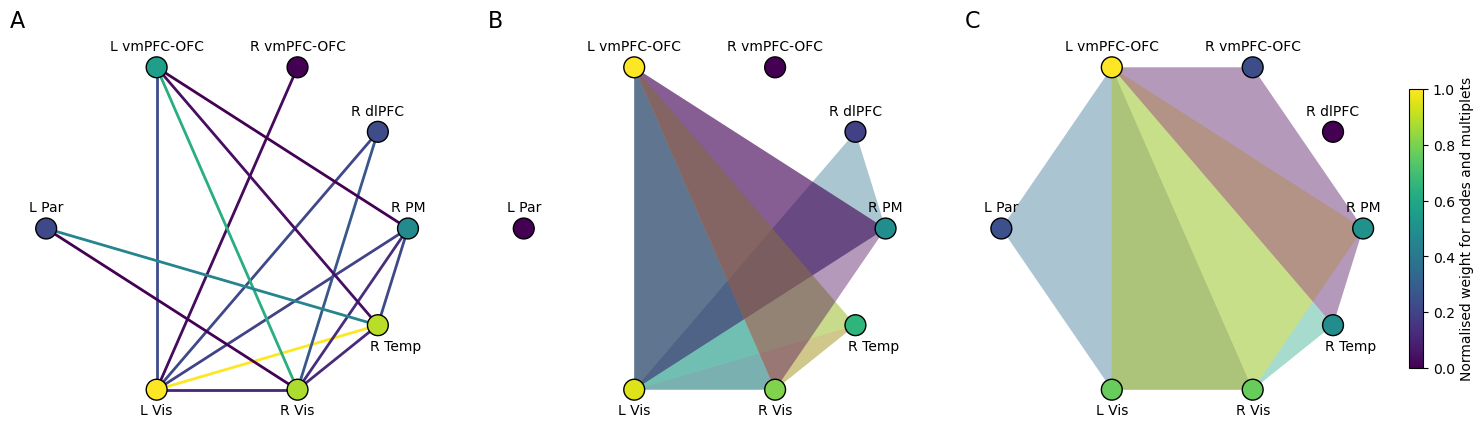

In [12]:
# Synergistic HOI data
syn = df.values

# ROI labels
list_rois = ['L_Visual', 'R_Visual', 'L_Parietal', 'R_Temporal', 'R_MotPM', 'R_dlPFC' , 'L_vmPFCOFC','R_vmPFCOFC']
# Short ROIS labels
list_rois_short = ['L Vis', 'R Vis', 'L Par', 'R Temp', 'R MotPM', 'R dlPFC' , 'L vmOFC','R vmOFC']

# Create list of links 
multiplets = list(df.index)
multiplets_splitted = [l.split('-') for l in multiplets]

# Create list of nodes within multiplets
for i, l in enumerate(multiplets_splitted):
    multiplets_splitted[i] = [list_rois.index(node) for node in l]
    
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Compute the multiple weight
multiplet_weight = data.values.sum(axis=1)
# Normalise the weight
multiplet_weight = (multiplet_weight - multiplet_weight.min()) / (multiplet_weight.max() - multiplet_weight.min())
# Loop over oders
for i, k in enumerate(range(2,5)):
    # Find the indices of the edges at a specific order
    ind_order = np.where(data.order == k)[0]
    # Multiple weights at order k
    weights = multiplet_weight[ind_order]
    # Take the rows indicated by ind_order of multiplets_splitted
    sublets = [multiplets_splitted[n] for n in ind_order]
    # append sublets and weights in the same line
    for j in range(len(sublets)):
         sublets[j].append(weights[j])
        
    # Create order-specific hypergraph
    H_k = xgi.Hypergraph()
    # Add nodes
    H_k.add_nodes_from(range(len(list_rois)))
    # H_k.add_nodes_from(list_rois)
    H_k.add_weighted_edges_from(sublets)
    # Create empy hypergraph
    H_empty = xgi.Hypergraph()
    # Add nodes
    H_empty.add_nodes_from(range(len(list_rois)))
    
    # Node colors
    node_color = df_node_weights.iloc[i].values
           
    # Normalise weights from 0 to 1
    weights_n = (weights - weights.min()) / (weights.max() - weights.min())
    cmap = cm.viridis(weights_n)
    
    # Add text to each panel
    axs[i].text(-1.2, 1.15, titles[i], fontsize=16)
    
    # Plot the hypergraph at each order
    if i==0:
        xgi.draw(H_k, pos=pos, ax=axs[i], node_fc=node_color, dyad_lw=2, dyad_color=cmap)  
        xgi.draw(H_empty, pos=pos_double, ax=axs[i], dyad_color='white', dyad_lw=1.5, \
            edge_fc='white', node_fc='white', node_ec='blue', node_lw=1, node_size=0, max_order=2, \
                node_labels=node_id, hyperedge_labels=False, font_size_nodes=10)
        
    else:
        xgi.draw(H_k, pos=pos, ax=axs[i], node_fc=node_color, edge_fc=cmap) 
        xgi.draw(H_empty, pos=pos_double, ax=axs[i], dyad_color='white', dyad_lw=1.5, \
            edge_fc='white', node_fc='white', node_ec='blue', node_lw=1, node_size=0, max_order=2, \
                node_labels=node_id, hyperedge_labels=False, font_size_nodes=10)  

        
# Append the colorbar
sm = cm.ScalarMappable(cmap='viridis')
sm.set_array(weights_n)
cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.01, pad=0.02)
# Set the label of the colorbar on top of the colorbar
cbar.set_label('Normalised weight for nodes and multiplets', fontsize=10)

